In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/cali_housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


/Users/bruno/miniconda3/envs/metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bruno/miniconda3/envs/metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


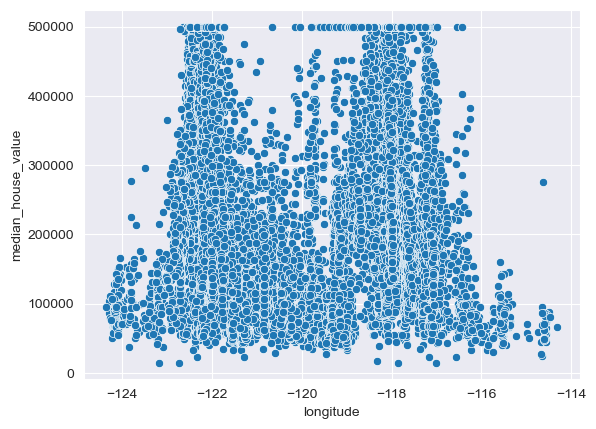

In [3]:
sns.scatterplot(x=df['longitude'], y=df['median_house_value'])
plt.savefig('scatterplot.png')

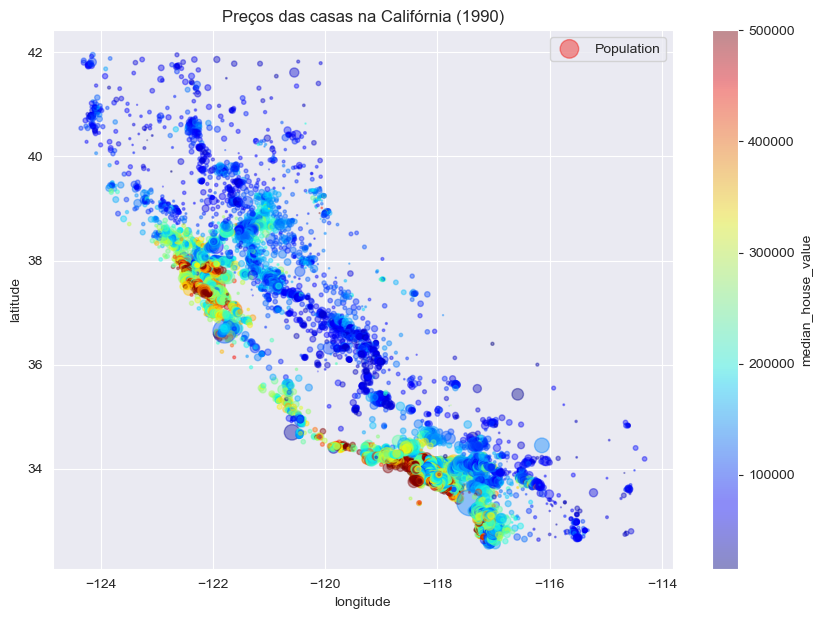

In [4]:
df.plot(kind='scatter', 
        x='longitude', 
        y='latitude', 
        alpha=0.4,
        s=df['population']/100,
        label='Population',
        figsize=(10,7),
        c="median_house_value",
        cmap=plt.get_cmap('jet'),
        colorbar=True,
        sharex=False)
plt.title('Preços das casas na Califórnia (1990)')
plt.legend()
plt.savefig('housing_prices_scatterplot.png')

In [5]:
from sklearn.tree import DecisionTreeRegressor

X = df[['longitude']]
y = df[['median_house_value']]

dtrl = DecisionTreeRegressor(max_depth=2, random_state=1)

dtrl.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=1)

/Users/bruno/miniconda3/envs/metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bruno/miniconda3/envs/metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


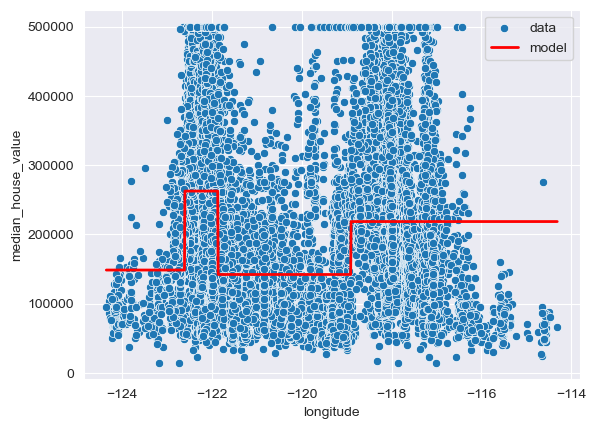

In [6]:
sns.scatterplot(x=df['longitude'], y=df['median_house_value'], label='data')
plt.plot(df['longitude'].sort_values(),
         dtrl.predict(df['longitude'].sort_values().to_frame()),
         color='red',
         label='model',
         linewidth=2)
plt.legend()
plt.savefig('model.png')

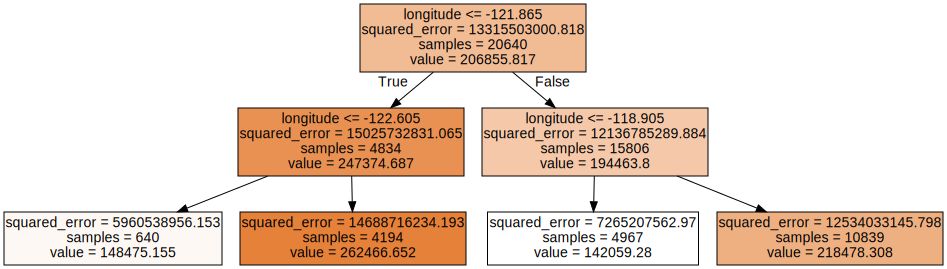

In [7]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dtrl, 
                           feature_names=['longitude'], 
                           filled=True,
                           rounded=False)
graph = graphviz.Source(dot_data)
graph

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.10, 
                                                    random_state=0, 
                                                    shuffle=True)

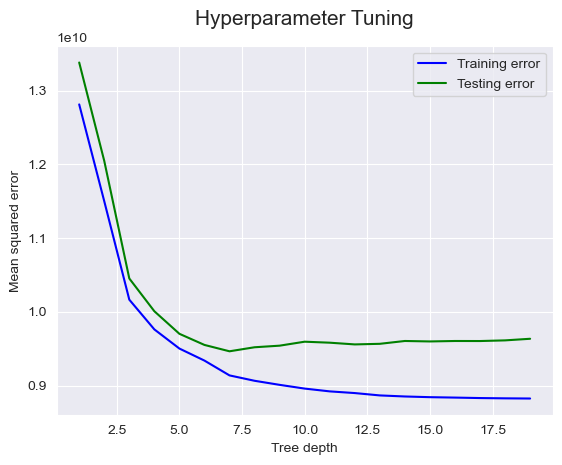

In [10]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 20)

training_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    model_1.fit(X, y)
    training_error.append(mse(y, model_1.predict(X)))
    
testing_error = []
for max_depth in max_depths:
    model_2 = DecisionTreeRegressor(max_depth=max_depth)
    model_2.fit(X_train, y_train)
    testing_error.append(mse(y_test, model_2.predict(X_test)))
    
plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
plt.savefig('error.png')


In [13]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor()

gs = GridSearchCV(model,
                  param_grid={'max_depth': range(1, 11),
                              'min_samples_split': range(10, 60, 10)},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=1,
             param_grid={'max_depth': range(1, 11),
                         'min_samples_split': range(10, 60, 10)},
             scoring='neg_mean_squared_error')

In [16]:
print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 9, 'min_samples_split': 50}
9363438182.696402


/Users/bruno/miniconda3/envs/metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bruno/miniconda3/envs/metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


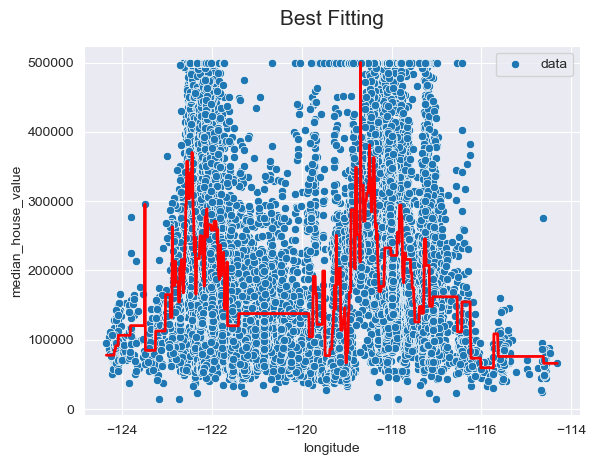

In [19]:
sns.scatterplot(x=df['longitude'],
                y=df['median_house_value'],
                label='data')

new_model = DecisionTreeRegressor(max_depth=gs.best_params_['max_depth'],
                                  min_samples_split=gs.best_params_['min_samples_split'])

new_model.fit(X_train, y_train)

plt.plot(df['longitude'].sort_values(),
         new_model.predict(df['longitude'].sort_values().to_frame()),
         color='red',
         label='model',
         linewidth=2)
plt.title('Best Fitting', pad=15, size=15)
plt.savefig('new_model.png')